In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import keras from tensorflow
from tensorflow import keras
from sklearn.model_selection import train_test_split


from tensorflow.keras import models, layers, optimizers, losses, callbacks

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Loading & Analysing the Data

In [3]:
df = pd.read_csv('./drive/MyDrive/Age Gender Deep Learning/data/age_gender.csv')

In [4]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels
16563,43,3,0,20170119181404861.jpg.chip.jpg,180 180 181 181 180 180 179 157 106 68 62 69 8...
8344,26,4,0,20170103214633693.jpg.chip.jpg,73 31 17 8 21 48 97 124 148 158 157 164 163 16...
12584,33,0,1,20170105183847334.jpg.chip.jpg,117 78 35 77 84 57 50 82 113 140 156 171 170 1...
5223,24,2,1,20170116163750637.jpg.chip.jpg,145 155 156 155 157 155 160 162 165 167 170 17...
21053,62,0,0,20170120223830886.jpg.chip.jpg,250 250 250 250 249 249 249 249 247 234 223 22...


In [5]:
df.iloc[0, :]

age                                                          1
ethnicity                                                    2
gender                                                       0
img_name                        20161219203650636.jpg.chip.jpg
pixels       129 128 128 126 127 130 133 135 139 142 145 14...
Name: 0, dtype: object

In [6]:
df = df.drop(['img_name'], axis = 1)

In [7]:
X = df['pixels'].apply(lambda x : np.array(x.split(), dtype = float))
X_bar = [np.array([val for val in X[i]]).reshape(48, 48, 1) for i in range(X.shape[0])]

In [8]:
X = np.array(X_bar)
X = X/255.0

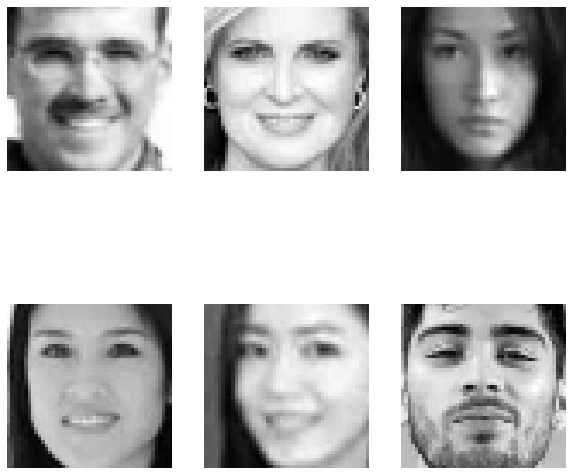

In [9]:
fig = plt.figure(figsize = (10,10))
i = 6
while i:
    x = np.random.randint(0, 20000)
    plt.subplot(2, 3, i)
    plt.imshow(X[x].reshape(48, 48), cmap='gray')
#     print(Y[x])
    plt.axis ('off')
    i -= 1
plt.show()

In [10]:
Y_gender = df['gender']
Y_age = df['age']

In [11]:
print(Y_gender)
print(Y_age)

0        0
1        0
2        0
3        0
4        0
        ..
23700    1
23701    1
23702    1
23703    1
23704    1
Name: gender, Length: 23705, dtype: int64
0         1
1         1
2         1
3         1
4         1
         ..
23700    99
23701    99
23702    99
23703    99
23704    99
Name: age, Length: 23705, dtype: int64


### Split training and Testing Data

In [12]:
x_train, x_test, y_train_gender, y_test_gender, y_train_age, y_test_age = train_test_split(
    X, Y_gender,Y_age, test_size=0.1, random_state=1)
# X_val, X_test, y_val, y_test = train_test_split(X, Y, test_size = 0.5, random_state = 1)

Our Model

In [13]:
input = layers.Input(shape=(48,48,1))
conv_layer = layers.Conv2D(32, (3, 3), activation='relu')(input)
batch_norm = layers.BatchNormalization()(conv_layer)
max_pool = layers.MaxPooling2D((2, 2))(batch_norm)
conv_layer = layers.Conv2D(64, (3, 3), activation='relu')(max_pool)
max_pool = layers.MaxPooling2D((2, 2))(conv_layer)

flatten = layers.Flatten()(max_pool)

gender_class = layers.Dense(64, activation='relu')(flatten)
gender_class = layers.Dropout(rate=0.5)(gender_class)
gender_output = layers.Dense(1, activation='sigmoid', name='gender')(gender_class)

age_output = layers.Dense(32, activation='relu')(flatten)
age_output = layers.Dropout(0.5)(age_output)
age_output = layers.Dense(1, activation='linear', name='age')(age_output)

model = models.Model(input, [gender_output, age_output])

sgd = optimizers.SGD(momentum=0.9)

model.compile(
    optimizer=optimizers.RMSprop(),
    loss={
        'gender': losses.BinaryCrossentropy(), 
        'age': losses.MeanSquaredError()
    },
    loss_weights={
        'gender':.75, 
        'age':0.25,
    },
    metrics={
        'gender':'accuracy', 
        'age':'mae'
    }
)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 23, 23, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

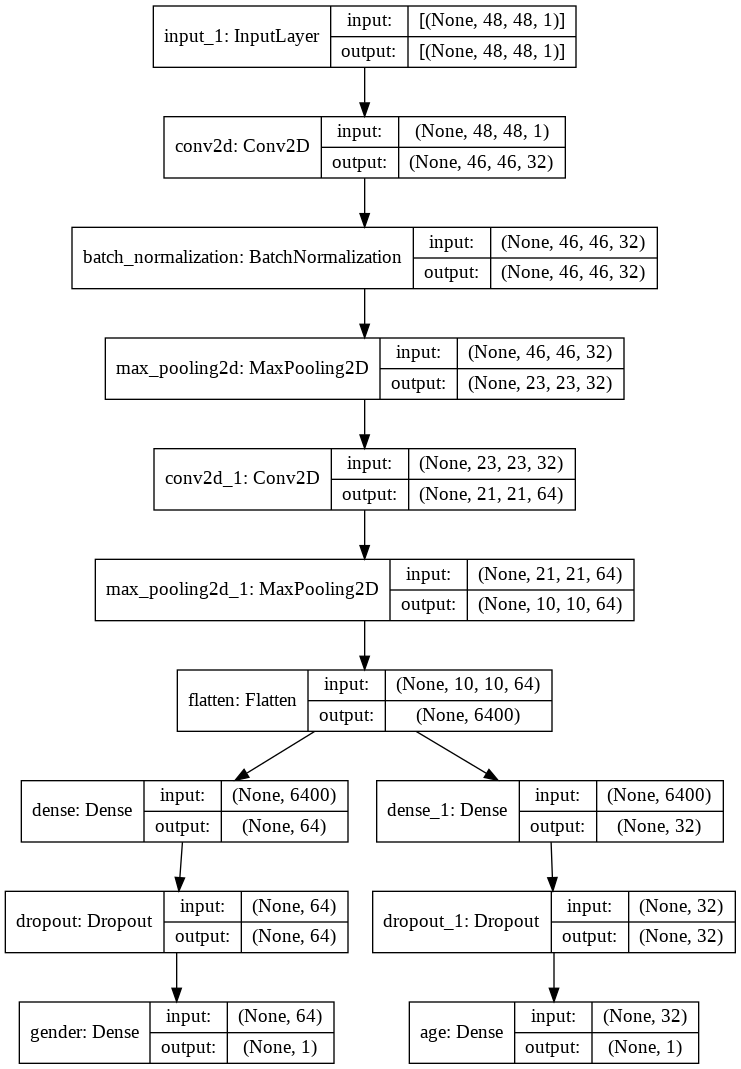

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
callbacks_list = [
                  callbacks.ReduceLROnPlateau(
                      monitor='val_loss',
                      factor=0.5,
                      patience=1
                  ),
                  callbacks.EarlyStopping(
                      monitor='val_loss',
                      patience=5,
                  )
]

In [17]:
history = model.fit(x_train, [y_train_gender, y_train_age], validation_split=0.1, epochs = 50, batch_size=32, callbacks=callbacks_list)

Epoch 1/50
600/600 [==============================] - 37s 11ms/step - loss: 97.8583 - gender_loss: 0.6255 - age_loss: 389.5565 - gender_accuracy: 0.6994 - age_mae: 15.0428 - val_loss: 118.1648 - val_gender_loss: 0.3856 - val_age_loss: 471.5023 - val_gender_accuracy: 0.8351 - val_age_mae: 16.6662
Epoch 2/50
600/600 [==============================] - 6s 10ms/step - loss: 63.1999 - gender_loss: 0.4090 - age_loss: 251.5727 - gender_accuracy: 0.8082 - age_mae: 11.9655 - val_loss: 47.5142 - val_gender_loss: 0.2855 - val_age_loss: 189.2004 - val_gender_accuracy: 0.8664 - val_age_mae: 9.8605
Epoch 3/50
600/600 [==============================] - 6s 10ms/step - loss: 55.5196 - gender_loss: 0.3727 - age_loss: 220.9606 - gender_accuracy: 0.8239 - age_mae: 11.0647 - val_loss: 50.3871 - val_gender_loss: 0.3472 - val_age_loss: 200.5067 - val_gender_accuracy: 0.8374 - val_age_mae: 11.4939
Epoch 4/50
600/600 [==============================] - 6s 10ms/step - loss: 48.4296 - gender_loss: 0.3232 - age_los

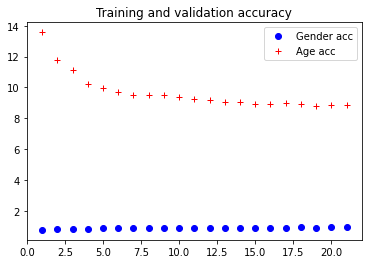

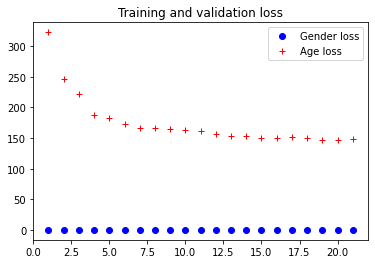

In [18]:
import matplotlib.pyplot as plt
g_acc = history.history['gender_accuracy']
a_acc = history.history['age_mae']
# val_acc = history.history['val_accuracy']
g_loss = history.history['gender_loss']
a_loss = history.history['age_loss']
# val_loss = history.history['val_loss']
epochs = range(1, len(g_acc) + 1)
plt.plot(epochs, g_acc, 'bo', label='Gender acc')
plt.plot(epochs, a_acc, 'r+', label='Age acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, g_loss, 'bo', label='Gender loss')
plt.plot(epochs, a_loss, 'r+', label='Age loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
model.evaluate(x_test, [y_test_gender, y_test_age])

75/75 [==============================] - 0s 5ms/step - loss: 22.3180 - gender_loss: 0.2388 - age_loss: 88.5555 - gender_accuracy: 0.9110 - age_mae: 6.8664


[22.317960739135742,
 0.23876561224460602,
 88.5555191040039,
 0.9110080003738403,
 6.866384983062744]

In [20]:
model.save('./drive/MyDrive/Age Gender Deep Learning/models/age_gender.h5')